Statistics about Dataloaders

In [15]:
from hf_ehr.utils import load_config_from_path
from hf_ehr.data.tokenization import CLMBRTokenizer
from hf_ehr.data.datasets import BaseDataset
from torch.utils.data import DataLoader
from hf_ehr.trainer.loaders import load_datasets, load_dataloaders
from omegaconf import OmegaConf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hf_ehr.config import PATH_TO_FEMR_EXTRACT_v8
from typing import Dict, List
from tqdm import tqdm
import json
 
# Load config
config = load_config_from_path('/share/pi/nigam/suhana/hf_ehr/cache/runs_backup/mamba-tiny-16384--clmbr/ckpts/train-tokens-total_nonPAD-ckpt_val=2000000000-persist.ckpt')
OmegaConf.set_struct(config, False)
config.data.dataset.path_to_femr_extract = PATH_TO_FEMR_EXTRACT_v8

# FEMRDataset

In [3]:
# Load dataloader
config.data.dataset.name = 'FEMRDataset'
tokenizer = CLMBRTokenizer( config.data.tokenizer.path_to_config )
datasets: Dict[str, BaseDataset] = load_datasets(config, tokenizer)
dataloaders: Dict[str, DataLoader] = load_dataloaders(config, datasets, tokenizer)

/home/mwornow/llama_hf_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
2024-10-27 23:33:05.612 | INFO     | hf_ehr.trainer.loaders:load_dataloaders:30 - ====> Loading ApproxBatchSampler


Loading `seq_length_per_patient.json` from `/share/pi/nigam/mwornow/hf_ehr/cache/tokenizers/clmbr_v8/versions/2024-07-20_05-21-33/datasets/2024-07-20_05-22-12/seq_length_per_patient.json` for split=`train`
Loading `seq_length_per_patient.json` from `/share/pi/nigam/mwornow/hf_ehr/cache/tokenizers/clmbr_v8/versions/2024-07-20_05-21-33/datasets/2024-07-21_10-55-32/seq_length_per_patient.json` for split=`val`
Loading `seq_length_per_patient.json` from `/share/pi/nigam/mwornow/hf_ehr/cache/tokenizers/clmbr_v8/versions/2024-07-20_05-21-33/datasets/2024-07-21_11-44-30/seq_length_per_patient.json` for split=`test`


In [5]:
# Loop through train dataloader, keeping track of all sequence lengths seen
if os.path.exists('../cache/train_seq_lengths-mamba-16k-FEMRDataset.json'):
    data = json.load(open('../cache/train_seq_lengths-mamba-16k-FEMRDataset.json', 'r'))
    train_seq_lengths: List[int] = data['train_seq_lengths']
else:
    train_seq_lengths: List[int] = []
    for batch in tqdm(dataloaders['train']):
        lengths = batch['tokens']['attention_mask'].sum(dim=1)
        assert len(lengths) == len(batch['patient_ids'])
        train_seq_lengths.extend(lengths)
    train_seq_lengths = [ x.item() for x in train_seq_lengths ]
    json.dump({ 'train_seq_lengths' : train_seq_lengths, }, open('../cache/train_seq_lengths-mamba-16k-FEMRDataset.json', 'w'))
    print("# of batches:", len(dataloaders['train']))
print("# of seqs:", len(train_seq_lengths))

# of seqs: 2567450


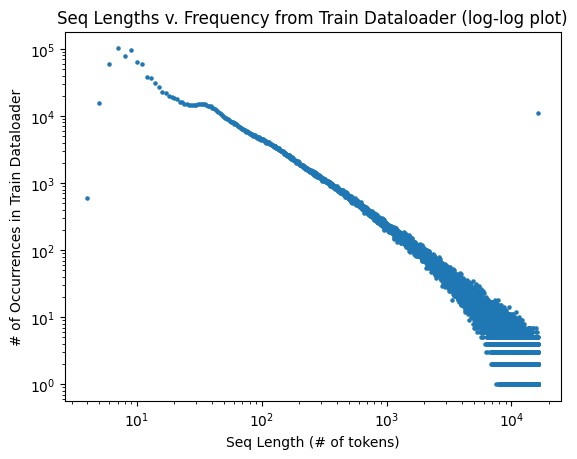

In [11]:
# Plot histogram of sequence lengths
from collections import Counter

counter = Counter(train_seq_lengths)
plt.scatter(list(counter.keys()), list(counter.values()), s=5)
plt.yscale('log')
plt.xscale('log')
plt.title('Seq Lengths v. Frequency from Train Dataloader (log-log plot)')
plt.xlabel('Seq Length (# of tokens)')
plt.ylabel('# of Occurrences in Train Dataloader')

# Show plot
plt.show()

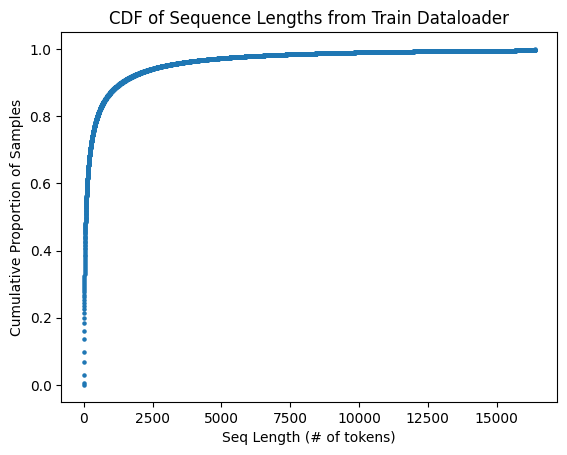

In [12]:
# Plot CDF of sequence lengths
seq_lengths = np.array(list(counter.keys()))
occurrences = np.array(list(counter.values()))
sorted_indices = np.argsort(seq_lengths)
sorted_seq_lengths = seq_lengths[sorted_indices]
sorted_occurrences = occurrences[sorted_indices]

# CDF is the cumulative sum of the occurrences divided by the total number of sequences
cdf = np.cumsum(sorted_occurrences) / np.sum(sorted_occurrences)

# Plot CDF
plt.scatter(sorted_seq_lengths, cdf, marker='o', linestyle='-', s=5)
plt.title('CDF of Sequence Lengths from Train Dataloader')
plt.xlabel('Seq Length (# of tokens)')
plt.ylabel('Cumulative Proportion of Samples')

# Show plot
plt.show()

In [17]:
# Percentiles

def print_percentiles(series):
    print("Percentiles:")
    print("0th percentile:", series.min())
    print("25th percentile:", series.quantile(0.25))
    print("50th percentile:", series.quantile(0.50))
    print("75th percentile:", series.quantile(0.75))
    print("90th percentile:", series.quantile(0.90))
    print("95th percentile:", series.quantile(0.95))
    print("99th percentile:", series.quantile(0.99))
    print("100th percentile:", series.max())

print_percentiles(pd.Series(train_seq_lengths))
print("\n")
print("% of sequences >=512", len([ x for x in train_seq_lengths if x >= 512 ]) / len(train_seq_lengths))
print("% of sequences >=768", len([ x for x in train_seq_lengths if x >= 768 ]) / len(train_seq_lengths))
print("% of sequences >=1024", len([ x for x in train_seq_lengths if x >= 1024 ]) / len(train_seq_lengths))
print("% of sequences >=2048", len([ x for x in train_seq_lengths if x >= 2048 ]) / len(train_seq_lengths))
print("% of sequences >=4096", len([ x for x in train_seq_lengths if x >= 4096 ]) / len(train_seq_lengths))
print("% of sequences >=8192", len([ x for x in train_seq_lengths if x >= 8192 ]) / len(train_seq_lengths))
print("% of sequences >=16384", len([ x for x in train_seq_lengths if x >= 16384 ]) / len(train_seq_lengths))

Percentiles:
0th percentile: 4
25th percentile: 17.0
50th percentile: 71.0
75th percentile: 338.0
90th percentile: 1380.0
95th percentile: 2954.0
99th percentile: 10235.0
100th percentile: 16384


% of sequences >=512 0.19680772751173342
% of sequences >=768 0.15198153810200782
% of sequences >=1024 0.12491888839120528
% of sequences >=2048 0.07142495472161094
% of sequences >=4096 0.035087343473095875
% of sequences >=8192 0.014223451284348283
% of sequences >=16384 0.004315566028549728


# AllTokensDataset

In [19]:
# Load dataloader
config.data.dataset.name = 'AllTokensFEMRDataset'
tokenizer = CLMBRTokenizer( config.data.tokenizer.path_to_config )
datasets: Dict[str, BaseDataset] = load_datasets(config, tokenizer)
dataloaders: Dict[str, DataLoader] = load_dataloaders(config, datasets, tokenizer)

Loading `seq_length_per_patient.json` from `/share/pi/nigam/mwornow/hf_ehr/cache/tokenizers/clmbr_v8/versions/2024-07-20_05-21-33/datasets/2024-07-25_09-12-22/seq_length_per_patient.json` for split=`train`
Loading `seq_length_per_patient.json` from `/share/pi/nigam/mwornow/hf_ehr/cache/tokenizers/clmbr_v8/versions/2024-07-20_05-21-33/datasets/2024-07-25_12-26-32/seq_length_per_patient.json` for split=`val`
Loading `seq_length_per_patient.json` from `/share/pi/nigam/mwornow/hf_ehr/cache/tokenizers/clmbr_v8/versions/2024-07-20_05-21-33/datasets/2024-07-25_13-11-48/seq_length_per_patient.json` for split=`test`


2024-10-27 23:39:15.900 | INFO     | hf_ehr.trainer.loaders:load_dataloaders:30 - ====> Loading ApproxBatchSampler


In [20]:
# Loop through train dataloader, keeping track of all sequence lengths seen
if os.path.exists('../cache/train_seq_lengths-mamba-16k-AllTokensFEMRDataset.json'):
    data = json.load(open('../cache/train_seq_lengths-mamba-16k-AllTokensFEMRDataset.json', 'r'))
    train_seq_lengths: List[int] = data['train_seq_lengths']
else:
    train_seq_lengths: List[int] = []
    for batch in tqdm(dataloaders['train']):
        lengths = batch['tokens']['attention_mask'].sum(dim=1)
        assert len(lengths) == len(batch['patient_ids'])
        train_seq_lengths.extend(lengths)
    train_seq_lengths = [ x.item() for x in train_seq_lengths ]
    json.dump({ 'train_seq_lengths' : train_seq_lengths, }, open('../cache/train_seq_lengths-mamba-16k-AllTokensFEMRDataset.json', 'w'))
    print("# of batches:", len(dataloaders['train']))
print("# of seqs:", len(train_seq_lengths))

# of seqs: 2582468


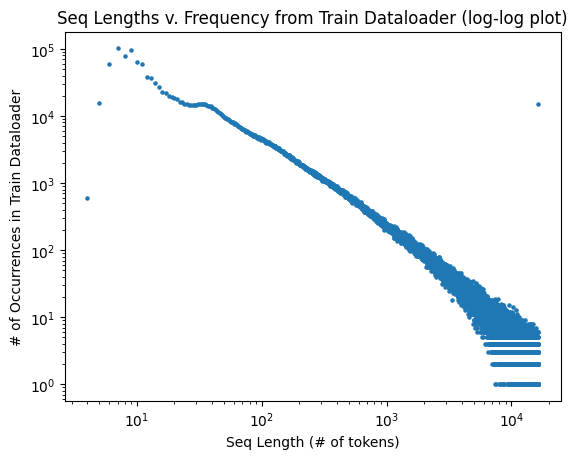

In [21]:
# Plot histogram of sequence lengths
from collections import Counter

counter = Counter(train_seq_lengths)
plt.scatter(list(counter.keys()), list(counter.values()), s=5)
plt.yscale('log')
plt.xscale('log')
plt.title('Seq Lengths v. Frequency from Train Dataloader (log-log plot)')
plt.xlabel('Seq Length (# of tokens)')
plt.ylabel('# of Occurrences in Train Dataloader')

# Show plot
plt.show()

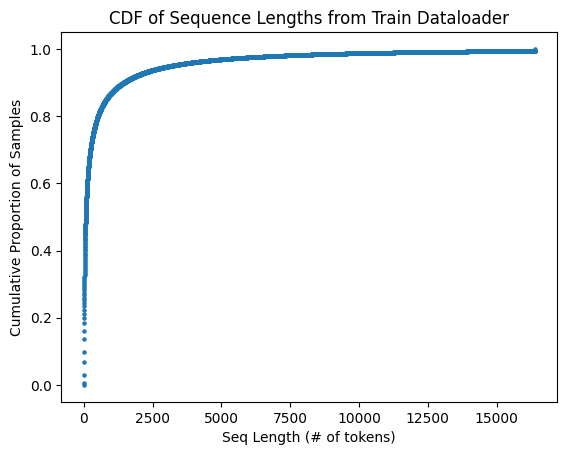

In [22]:
# Plot CDF of sequence lengths
seq_lengths = np.array(list(counter.keys()))
occurrences = np.array(list(counter.values()))
sorted_indices = np.argsort(seq_lengths)
sorted_seq_lengths = seq_lengths[sorted_indices]
sorted_occurrences = occurrences[sorted_indices]

# CDF is the cumulative sum of the occurrences divided by the total number of sequences
cdf = np.cumsum(sorted_occurrences) / np.sum(sorted_occurrences)

# Plot CDF
plt.scatter(sorted_seq_lengths, cdf, marker='o', linestyle='-', s=5)
plt.title('CDF of Sequence Lengths from Train Dataloader')
plt.xlabel('Seq Length (# of tokens)')
plt.ylabel('Cumulative Proportion of Samples')

# Show plot
plt.show()

In [23]:
# Percentiles
print_percentiles(pd.Series(train_seq_lengths))
print("\n")
print("% of sequences >=512", len([ x for x in train_seq_lengths if x >= 512 ]) / len(train_seq_lengths))
print("% of sequences >=768", len([ x for x in train_seq_lengths if x >= 768 ]) / len(train_seq_lengths))
print("% of sequences >=1024", len([ x for x in train_seq_lengths if x >= 1024 ]) / len(train_seq_lengths))
print("% of sequences >=2048", len([ x for x in train_seq_lengths if x >= 2048 ]) / len(train_seq_lengths))
print("% of sequences >=4096", len([ x for x in train_seq_lengths if x >= 4096 ]) / len(train_seq_lengths))
print("% of sequences >=8192", len([ x for x in train_seq_lengths if x >= 8192 ]) / len(train_seq_lengths))
print("% of sequences >=16384", len([ x for x in train_seq_lengths if x >= 16384 ]) / len(train_seq_lengths))

Percentiles:
0th percentile: 4
25th percentile: 17.0
50th percentile: 72.0
75th percentile: 349.0
90th percentile: 1462.0
95th percentile: 3199.0
99th percentile: 11735.330000000075
100th percentile: 16384


% of sequences >=512 0.20119242523043848
% of sequences >=768 0.1564751237963065
% of sequences >=1024 0.12943432406519656
% of sequences >=2048 0.07574963174761508
% of sequences >=4096 0.03878847675944097
% of sequences >=8192 0.01687107061926808
% of sequences >=16384 0.0058169162212271365
